In [13]:
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import os
import torch.onnx
import sklearn

In [14]:
# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use the default GPU device
else:
    device = torch.device("cpu")
print(device)

cuda


## Data Exploration

In [15]:
dataframes = []
train_data_directory = "Train"
for file in os.listdir(train_data_directory):
    dataframes.append(pd.read_csv(os.path.join(train_data_directory, file), delimiter=",").iloc[:,:-1])
    print(f"{len(dataframes)-1}:{file}")

0:User27_LinearPursuit_1.txt
1:User27_RapidAvoid_0.txt
2:User27_RapidMovement_0.txt
3:User27_RapidAvoid_1.txt
4:User27_ArcPursuit_0.txt
5:User27_ArcPursuit_1.txt
6:User27_LinearPursuit_0.txt
7:User27_RapidMovement_1.txt


In [16]:
for j in range(len(dataframes)):
    df = dataframes[j]
    labelx = []
    labely = []
    labelz = []
    for i in range(df.shape[0] - 1):
        label_row = df.iloc[i + 1]
        labelx.append(label_row["forward.x"])
        labely.append(label_row["forward.y"])
        labelz.append(label_row["forward.z"])
    ##  change the gaze z axis value
    df = df.drop(columns = ['gaze_direct_L.z','gaze_direct_R.z'])
    ##
    df = df.iloc[:-1, :]
    df["label.x"] = labelx
    df["label.y"] = labely
    df["label.z"] = labelz
    dataframes[j] = df

dataframes[3].head(5)

,time(100ns),time_stamp(ms),frame,gaze_direct_L.x,gaze_direct_L.y,gaze_direct_R.x,gaze_direct_R.y,forward.x,forward.y,forward.z,label.x,label.y,label.z
0,638213151622831262,1359973,116724,0.030411,0.029282,0.049759,0.030350,-0.058362,0.275746,0.959457,-0.058362,0.275746,0.959457
1,638213151622911260,1359981,116724,0.030228,0.029358,0.049637,0.029861,-0.058362,0.275746,0.959457,-0.058291,0.275651,0.959489
2,638213151622991263,1359989,116725,0.031174,0.032684,0.049606,0.030304,-0.058291,0.275651,0.959489,-0.058256,0.275747,0.959463
3,638213151623071266,1359997,116726,0.031235,0.033218,0.049316,0.030075,-0.058256,0.275747,0.959463,-0.058048,0.275601,0.959518
4,638213151623161262,1360006,116727,0.031372,0.033615,0.049316,0.030075,-0.058048,0.275601,0.959518,-0.058048,0.275601,0.959518


In [17]:
min_size = float('inf')
for df in dataframes:
    if df.shape[0] < min_size:
        min_size = df.shape[0]

for i in range(len(dataframes)):
    dataframes[i] = dataframes[i][:min_size]


len(dataframes), min_size


(8, 10799)

(10799, 13)


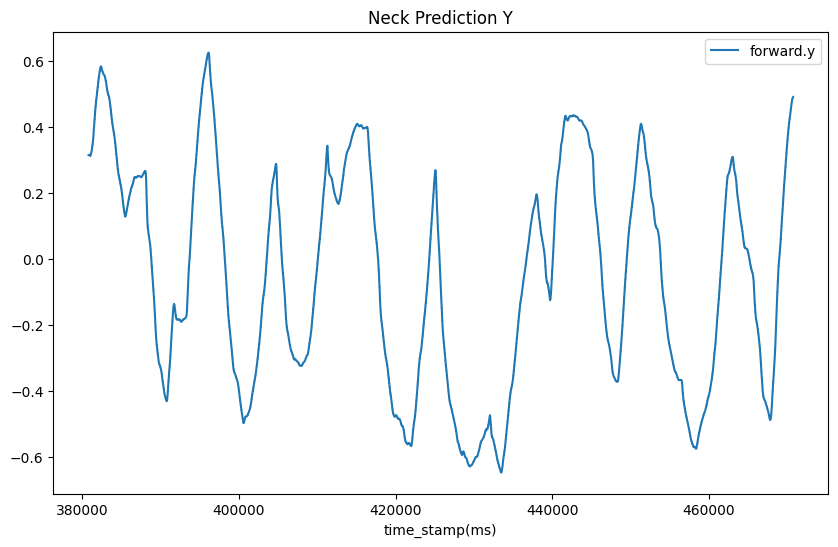

(10799, 13)


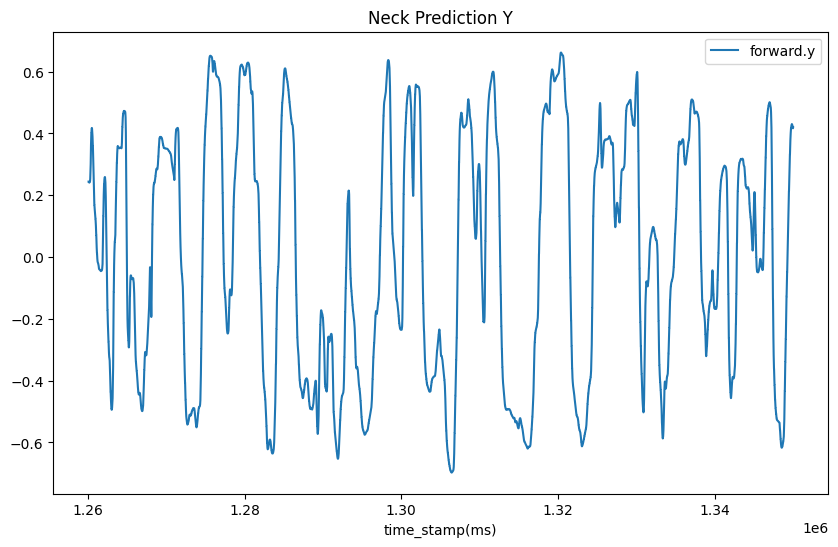

(10799, 13)


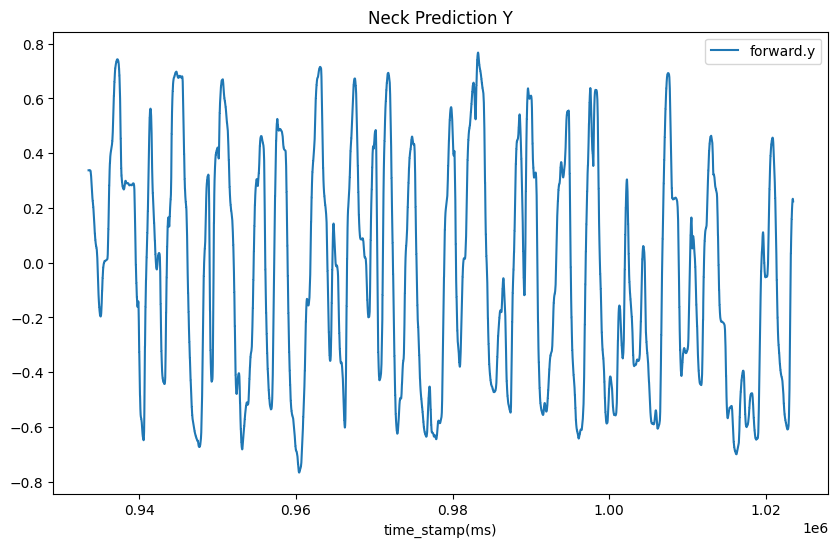

(10799, 13)


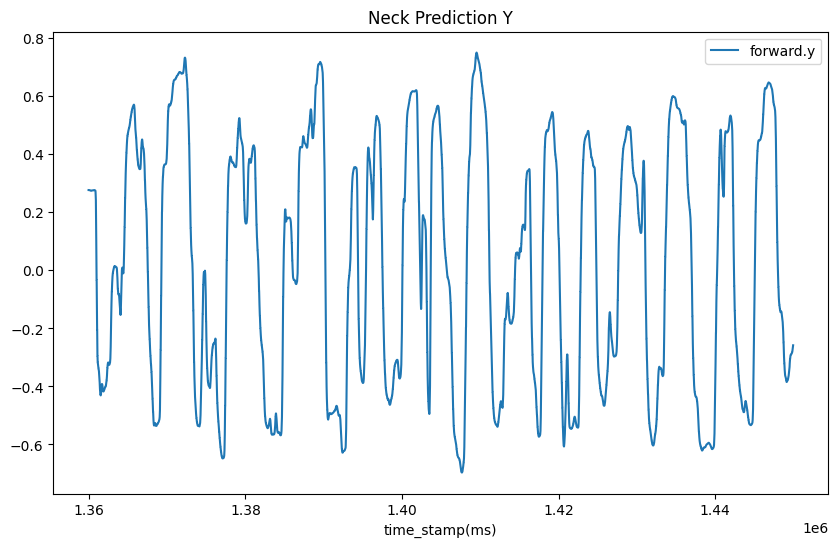

(10799, 13)


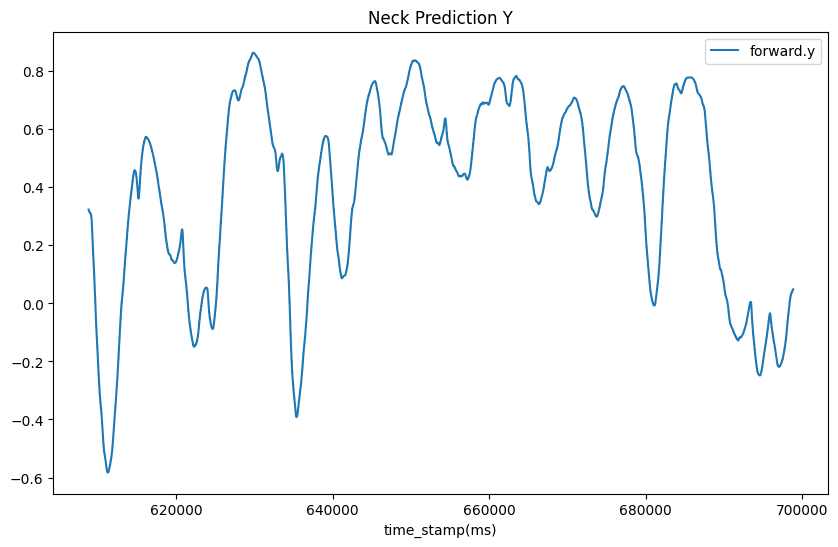

(10799, 13)


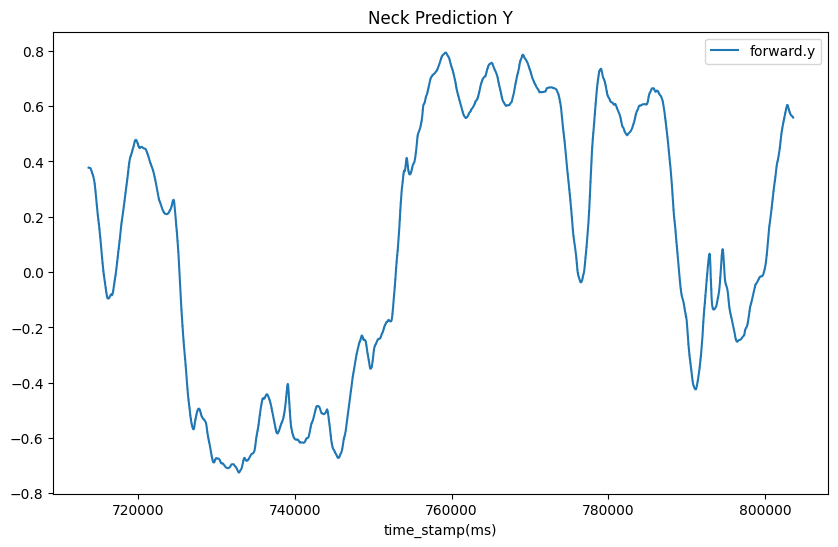

(10799, 13)


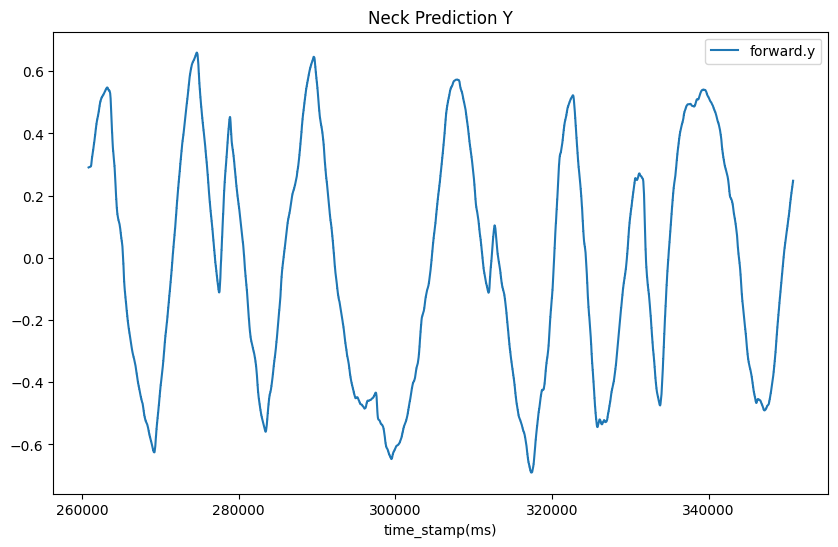

(10799, 13)


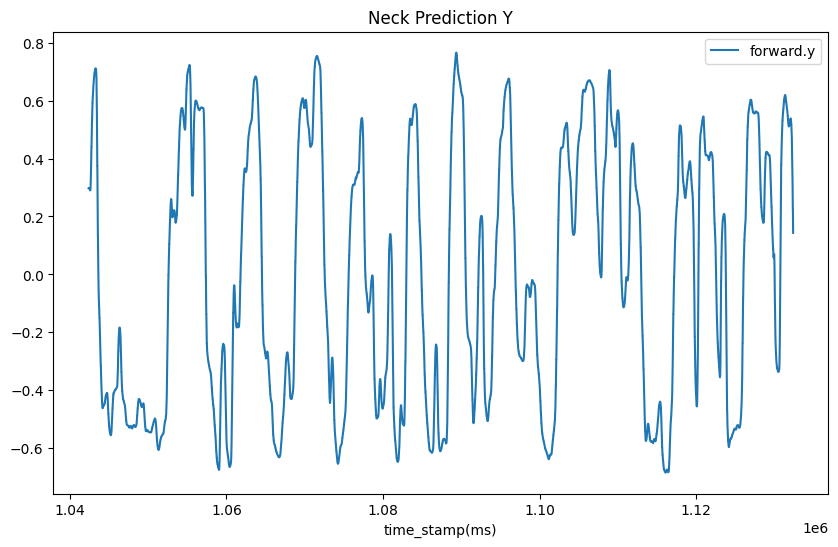

In [18]:
for df in dataframes:
    print(df.shape)
    plt.figure(figsize=(10,6))
    x = df["time_stamp(ms)"]
    plt.xlabel("time_stamp(ms)")

    #plt.plot(x, df["gaze_direct_L.z"], label = "gaze_direct_L.z")
    plt.plot(x, df["forward.y"], label="forward.y")


    plt.title(f"Neck Prediction Y")
    plt.legend()
    plt.show()

(10799, 13)


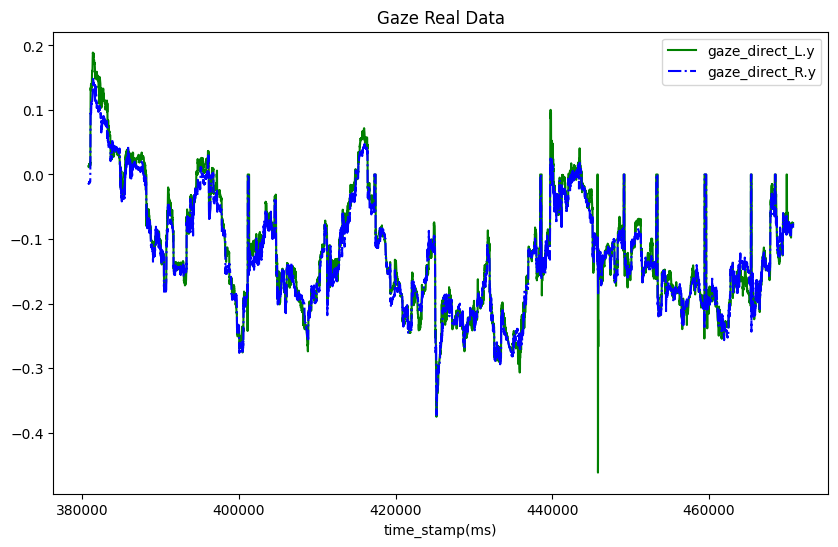

(10799, 13)


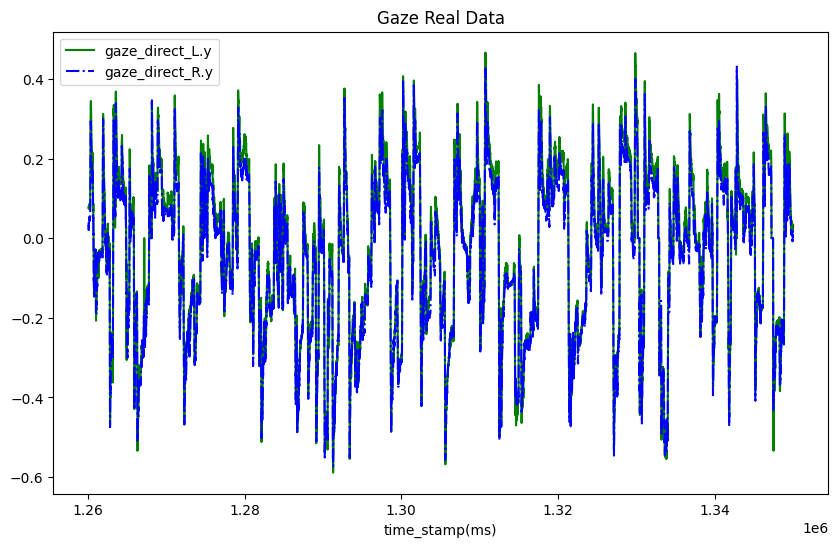

(10799, 13)


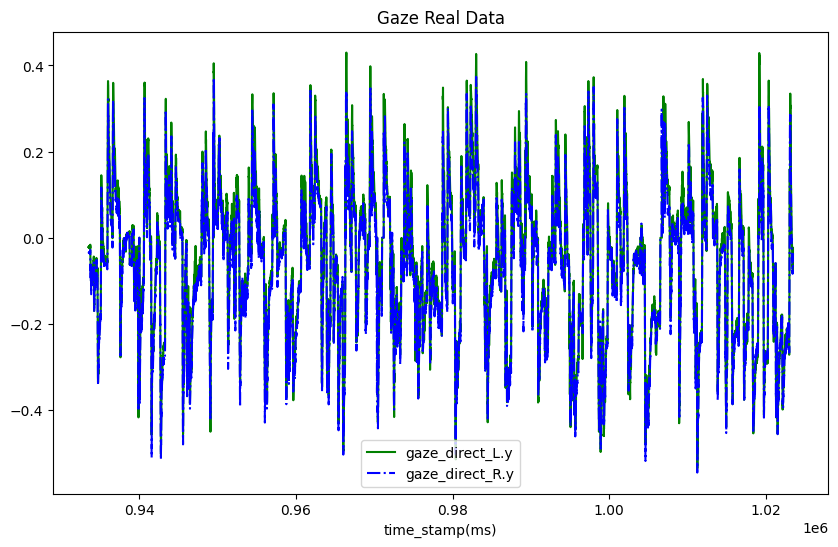

(10799, 13)


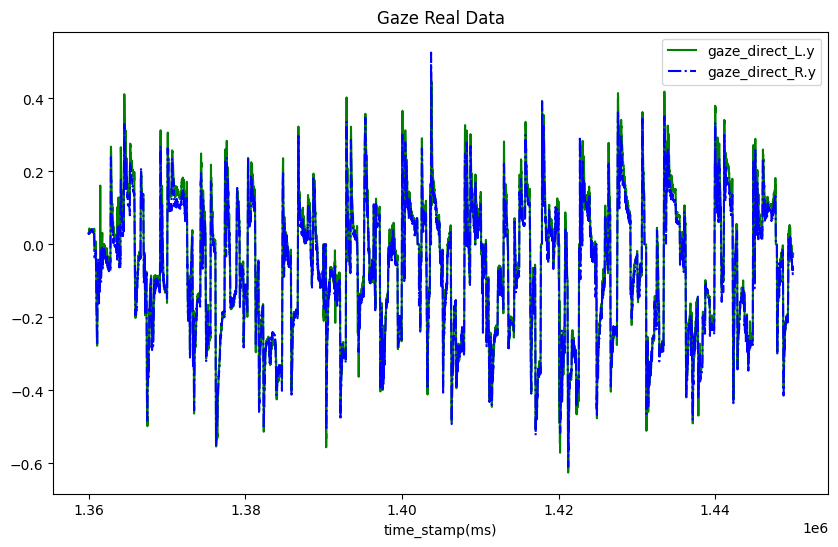

(10799, 13)


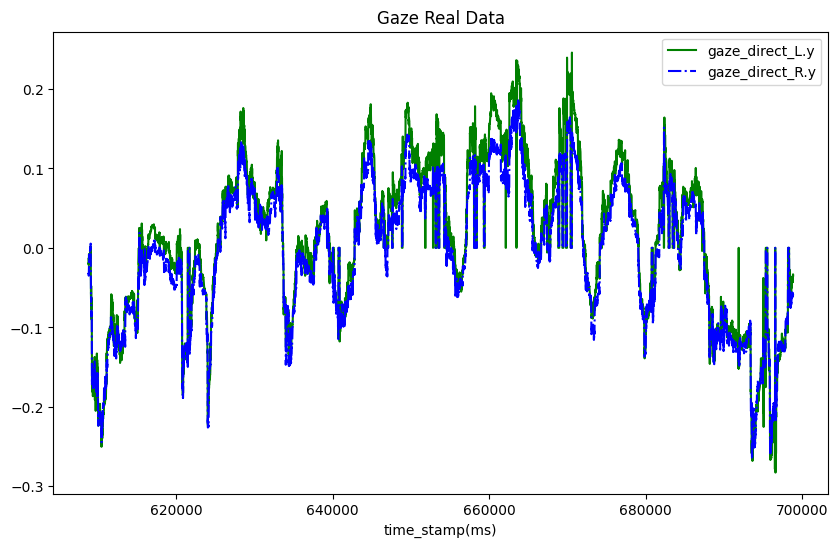

(10799, 13)


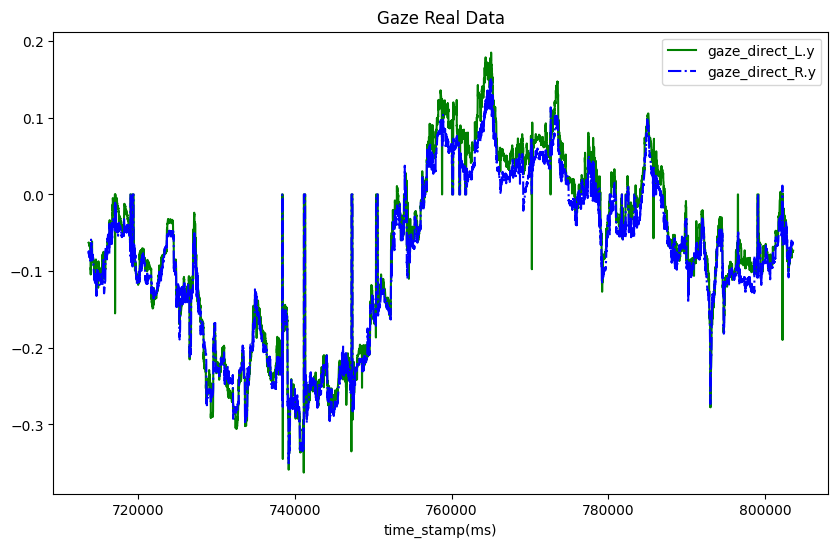

(10799, 13)


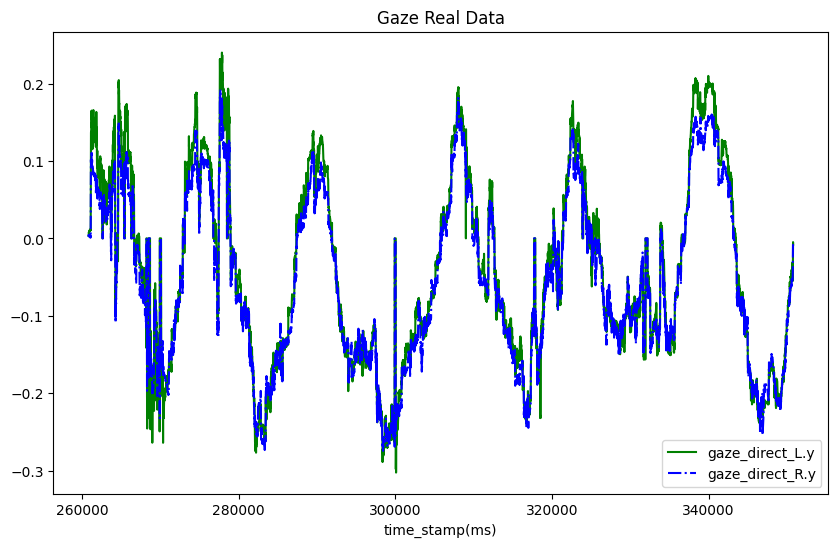

(10799, 13)


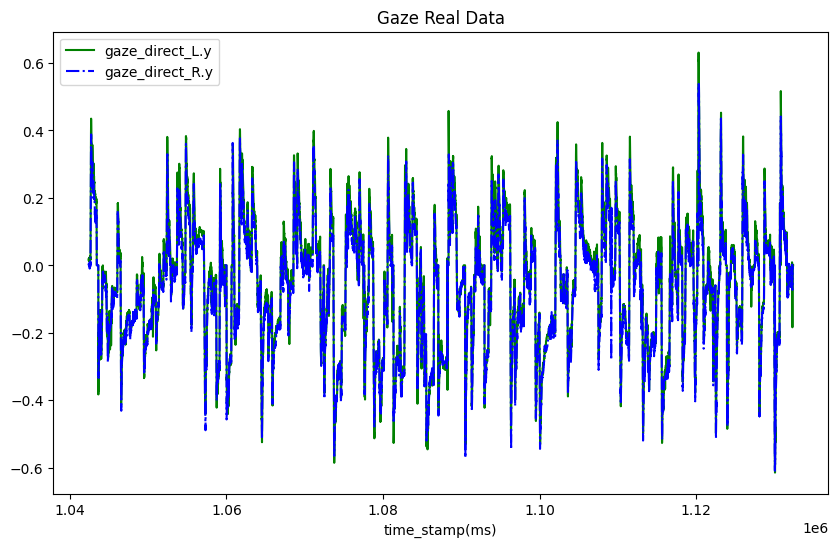

In [19]:
for df in dataframes:
    print(df.shape)
    plt.figure(figsize=(10,6))
    x = df["time_stamp(ms)"]
    plt.xlabel("time_stamp(ms)")

    #plt.plot(x, df['gaze_direct_L.x'],'b-', label = "gaze_direct_L.x")
    #plt.plot(x, df['gaze_direct_R.x'],'g-.', label = "gaze_direct_R.x")
    plt.plot(x, df['gaze_direct_L.y'],'g-', label = "gaze_direct_L.y")
    plt.plot(x, df['gaze_direct_R.y'],'b-.', label = "gaze_direct_R.y")



    plt.title(f"Gaze Real Data")
    plt.legend()
    plt.show()

(10799, 13)


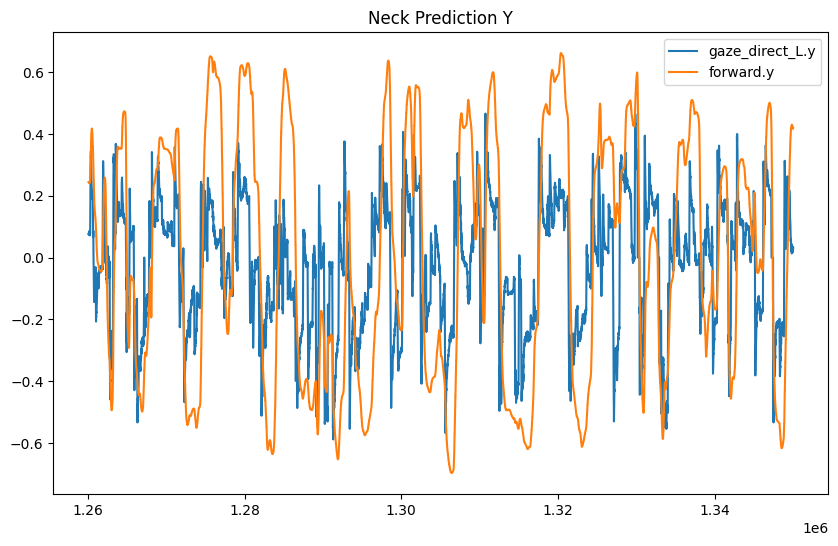

In [20]:
#The chat shows the relation of gaze and forward in the raw data.

df = dataframes[1]
print(df.shape)
plt.figure(figsize=(10,6))
x = df["time_stamp(ms)"]


plt.plot(x, df["gaze_direct_L.y"], label = "gaze_direct_L.y")
plt.plot(x, df["forward.y"], label="forward.y")

plt.title("Neck Prediction Y")
plt.legend()
plt.show()


## GRU Model

In [21]:
X_series = []
y_series = []
for df in dataframes:
    X = df.iloc[:, 3:-3].to_numpy() # gaze data and forward data
    y = df.iloc[:, -3:].to_numpy()  # label data

    X = Variable(torch.Tensor(X)) # trnsform to Tensor object (2d)
    y = Variable(torch.Tensor(y))

    X = torch.reshape(X, (X.shape[0], 1, X.shape[1])) # 3d Tensor object
    X_series.append(X)
    y_series.append(y)


X_series = torch.cat(X_series, dim=1)

y_series = torch.stack(y_series, dim=1)
print(X_series.shape, y_series.shape)

torch.Size([10799, 8, 7]) torch.Size([10799, 8, 3])


In [27]:
class CustomLSTM(nn.Module):
    def __init__(self, input_size, output_size=3, hidden_size=7):
        super(CustomLSTM, self).__init__() ##nn.Module __init__()
        self.num_classes = output_size
        self.num_layers = 1
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size=self.input_size, hidden_size=self.hidden_size, num_layers=self.num_layers, batch_first=True)
        self.fc = nn.Sequential(
            nn.Tanh(),
            nn.Linear(self.hidden_size, 128),
            nn.Tanh(),
            nn.Linear(128, self.num_classes)
        )

    def forward(self, x, h_0=None, c_0 = None):
        if h_0 is None:
            h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device)
        if c_0 is None:
            c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(torch.device("cuda"))

        output, (hn, cn) = self.lstm(x, (h_0, c_0))
        _hn = hn.view(-1, self.hidden_size)
        out = self.fc(_hn)
        return out, hn, cn

In [28]:
torch.manual_seed(0)

torch.cuda.manual_seed(0)



model_0 = CustomLSTM(7).to(device)
model_0

CustomLSTM(
  (lstm): LSTM(7, 7, batch_first=True)
  (fc): Sequential(
    (0): Tanh()
    (1): Linear(in_features=7, out_features=128, bias=True)
    (2): Tanh()
    (3): Linear(in_features=128, out_features=3, bias=True)
  )
)

In [30]:
with torch.inference_mode():
   untrained_preds, hn , cn = model_0( X_series.to(device))

print(X_series.shape, y_series.shape)
print( untrained_preds.shape, hn.shape)

#print(f"First 5 LSTM predictions:\n{LSTM_preds[0,0,:]}")
print(f"First 5 untrained predictions:\n{untrained_preds[0,:]}")
print(f"\nFirst 5 labels:\n{y_series[0,0, :]}")
print(f'hn:{hn[:,:1,:]}')

training_range = int(X_series.shape[0]*0.8)
training_range




torch.Size([10799, 8, 7]) torch.Size([10799, 8, 3])
torch.Size([10799, 3]) torch.Size([1, 10799, 7])
First 5 untrained predictions:
tensor([-0.0070,  0.0738, -0.0178], device='cuda:0')

First 5 labels:
tensor([-0.0378,  0.3147,  0.9484])
hn:tensor([[[-0.0941,  0.0708,  0.0031, -0.1330, -0.1761, -0.0715,  0.0813]]],
       device='cuda:0')


8639

## Training Loop and Results

In [36]:
def train(model, X, y, optimizer, criterion, device):
    model.train()
    optimizer.zero_grad()
    preds = torch.zeros(y.shape).to(device)

    loss = 0

    for j in range(X.shape[1]):
        instance = X[0:1, j:j+1, :]

        hn = None
        cn = None

        for i in range(training_range):
            pred, hn , cn = model(instance, hn, cn)
            pred = nn.functional.normalize(pred)
            #preds[i, j] = pred
            cur_loss = criterion(pred, y[i:i+1, j])
            loss += criterion(pred, y[i:i+1, j]) / (training_range * X.shape[1])
            #losses.append(cur_loss.item())

            if i < training_range-1:
                #g_hat=h+g-pred(h_hat)
                l_pred = nn.functional.normalize(torch.reshape(X[i+1,j:j+1,-3:].to(device) + torch.cat((X_series[i+1,j:j+1,0:2].squeeze(),torch.tensor([1])),0).unsqueeze(0).to(device) - pred[0].to(device), (1,3)))
                r_pred = nn.functional.normalize(torch.reshape(X[i+1,j:j+1,-3:].to(device) + torch.cat((X_series[i+1,j:j+1,2:4].squeeze(),torch.tensor([1])),0).unsqueeze(0).to(device) - pred[0].to(device), (1,3)))

                instance = torch.reshape(torch.cat((l_pred, r_pred, pred), axis=1), (1,1,9))
                instance[0,0,2] =instance[0,0,5] = 10
                instance = instance[instance != instance[0,0,2] ].unsqueeze(0).unsqueeze(0)

    #loss = criterion(preds[:6000], y[:6000])
    loss.backward()
    optimizer.step()
    return loss.item()

In [37]:
def val(model, X, y, criterion, device):
    model.eval()

    preds = torch.zeros(y.shape).to(device)
    for j in range(X.shape[1]):
        #print(X.shape[1])
        instance = X[0:1, j:j+1, :]
        #print(instance)
        hn = None
        cn = None
        for i in range(X.shape[0]):
            #print(i)
            pred, hn , cn = model(instance, hn, cn)
            #print(pred)
            pred = nn.functional.normalize(pred)
            #print(pred)
            preds[i, j] = pred
            if i < X.shape[0] - 1:
                l_pred = nn.functional.normalize(torch.reshape(X[i+1,j:j+1,-3:].to(device) +  torch.cat((X_series[i+1,j:j+1,0:2].squeeze(),torch.tensor([1])),0).unsqueeze(0).to(device) - pred[0].to(device), (1,3)))
                r_pred = nn.functional.normalize(torch.reshape(X[i+1,j:j+1,-3:].to(device) +  torch.cat((X_series[i+1,j:j+1,2:4].squeeze(),torch.tensor([1])),0).unsqueeze(0).to(device) - pred[0].to(device), (1,3)))

                instance = torch.reshape(torch.cat((l_pred, r_pred, pred), axis=1), (1,1,9))
                instance[0,0,2] =instance[0,0,5] = 10
                instance = instance[instance != instance[0,0,2] ].unsqueeze(0).unsqueeze(0)

    loss = criterion(preds[training_range:], y[training_range:])
    return loss.item()

In [38]:
def train_loop(model, X, y, optimizer, device, scheduler, num_epochs):
    train_losses = []
    val_losses = []
    counter = 0
    X = X.to(device)
    y = y.to(device)

    min_val_loss = val(model, X, y, criterion, device)
    print(f"Initial loss:{min_val_loss}")
    for epoch in range(num_epochs):

        train_loss = train(model, X, y, optimizer, criterion, device)
        train_losses.append(train_loss)

        val_loss = val(model, X, y, criterion, device)
        val_losses.append(val_loss)

        print("Epoch: %d, train loss: %1.5f, val loss: %1.5f" % (epoch, train_loss,
                                                                 val_losses[epoch]))
        if val_losses[epoch] < min_val_loss:
            min_val_loss = val_losses[epoch]
            counter = 0
            torch.save(model.state_dict(), "best_val_lstm_woZ.pth")
        else:
            counter += 1
            if counter > 10:
                break

        if epoch+1 % 10 == 0:
            scheduler.step()

    return train_losses, val_losses

In [39]:

learning_rate = 0.01
criterion = torch.nn.MSELoss()

#device = torch.device("cuda")

lr_xyz = CustomLSTM(input_size=7).to(device)
optimizer = torch.optim.Adam(lr_xyz.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [40]:
train_losses, val_losses = train_loop(lr_xyz, X_series, y_series, optimizer, device, scheduler, 1000)

val
eval
train
torch.Size([1, 1, 7])
torch.Size([1, 1, 7])
torch.Size([1, 1, 7])
torch.Size([1, 1, 7])
torch.Size([1, 1, 7])
torch.Size([1, 1, 7])
torch.Size([1, 1, 7])
torch.Size([1, 1, 7])
val
eval


KeyboardInterrupt: ignored

In [ ]:
learning_rate = 0.0001
criterion = torch.nn.MSELoss()

device = torch.device("cuda")
lr_xyz = CustomLSTM(input_size=7).to(device)
lr_xyz.load_state_dict(torch.load("best_val_lstm_woZ.pth"))
optimizer = torch.optim.Adam(lr_xyz.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

FileNotFoundError: ignored

In [ ]:
torch.onnx.export(lr_xyz.cpu(),               # model being run
                  (X[0:1, 0:1, :], torch.zeros(1, 1, 7), torch.zeros(1, 1, 7)), # model input (or a tuple for multiple inputs)
                  "lr_xyz_lstm_woZ.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input', 'h0', 'c0'],   # the model's input names
                  output_names = ['output', 'hn', 'cn']) # the model's output names

C:\Users\Brown Research\Anaconda3\envs\EyeTracking\lib\site-packages\torch\onnx\symbolic_opset9.py:4315: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn(
C:\Users\Brown Research\Anaconda3\envs\EyeTracking\lib\site-packages\torch\onnx\_internal\jit_utils.py:258: UserWarning: The shape inference of prim::Constant type is missing, so it may result in wrong shape inference for the exported graph. Please consider adding it in symbolic function. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\jit\passes\onnx\shape_type_inference.cpp:1888.)
  _C._jit_pass_onnx_node_shape_type_inference(node, params_dict, opset_version)
C:\Users\Brown Research\Anaconda3\envs\EyeTracking\lib\site-packages\torch\onnx\utils.py:687: Use

<b>Result<b>

In [ ]:
X = X_series[:, 0:1, :]
y = y_series[:, 0, :]

print(X.shape, y.shape)
lr_xyz.to(device)

torch.Size([7195, 1, 9]) torch.Size([7195, 3])


CustomLSTM(
  (lstm): LSTM(9, 9, batch_first=True)
  (fc): Sequential(
    (0): Tanh()
    (1): Linear(in_features=9, out_features=128, bias=True)
    (2): Tanh()
    (3): Linear(in_features=128, out_features=3, bias=True)
  )
)

In [ ]:
train_predict, _, _ = lr_xyz(X.to(device))
data_predict = np.array([X[0, 0, 6:9].data.numpy()])
data_predict = np.append(data_predict, train_predict.data.cpu().numpy(), axis=0)

dataY_plot = np.array([X[0, 0, 6:9].data.numpy()])
dataY_plot = np.append(dataY_plot, y.data.numpy(), axis=0)
print(data_predict.shape, dataY_plot.shape)

(7196, 3) (7196, 3)


In [ ]:
data_compound = [X[0, 0, 6:9].data.numpy()]
hn = None
cn = None
for i in range(X.size(0)):
    instance = X[i:i+1]
    pred, hn, cn = lr_xyz(instance.to(device), hn, cn)
    pred = nn.functional.normalize(pred)
    pred = pred.data.cpu().numpy()
    cur = X[i, 0, 6:9].data.numpy()
    data_compound.append(pred[0])
    if i < X.size(0) - 1:
        X[i+1,0,0:3] = nn.functional.normalize(torch.reshape(X[i+1,0,6:9] + X[i+1,0,0:3] - torch.Tensor(pred[0]), (1,3))).view(-1,3)
        X[i+1,0,3:6] = nn.functional.normalize(torch.reshape(X[i+1,0,6:9] + X[i+1,0,3:6] - torch.Tensor(pred[0]), (1,3))).view(-1,3)
        X[i+1,0,6] = pred[0,0].item()
        X[i+1,0,7] = pred[0,1].item()
        X[i+1,0,8] = pred[0,2].item()
data_compound = np.array(data_compound)
print(data_compound.shape)

(7196, 3)


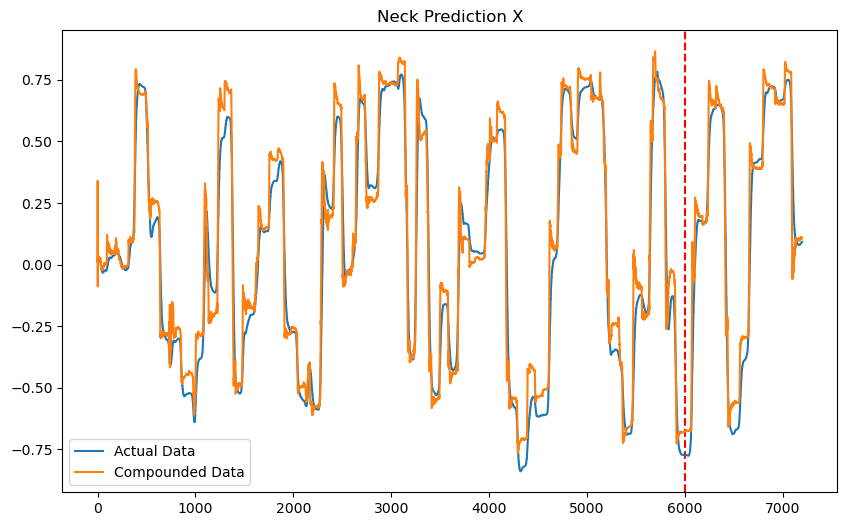

In [ ]:
plt.figure(figsize=(10,6))
plt.axvline(x=6000, c='r', linestyle="--")

plt.plot(dataY_plot[:, 0], label="Actual Data")
#plt.plot(data_predict[:, 0], label="Predicted Data")
plt.plot(data_compound[:, 0], label="Compounded Data")
plt.title("Neck Prediction X")
plt.legend()
plt.show()

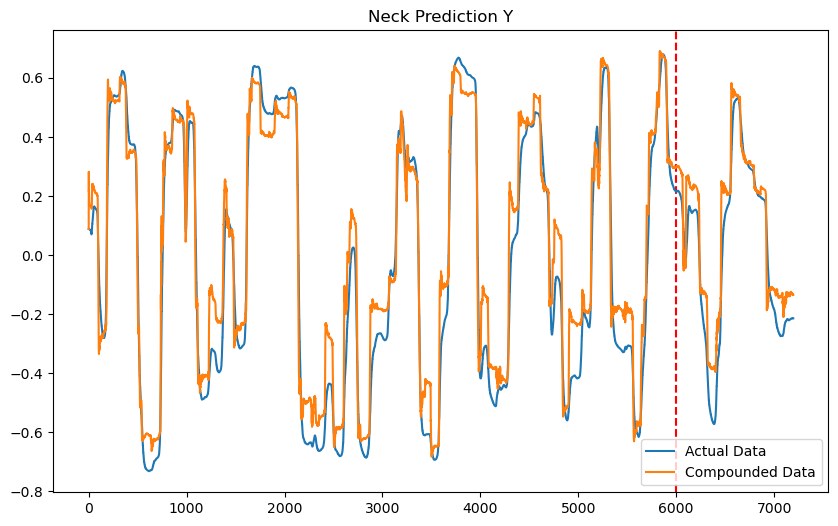

In [ ]:
plt.figure(figsize=(10,6))
plt.axvline(x=6000, c='r', linestyle="--")

plt.plot(dataY_plot[:, 1], label="Actual Data")
#plt.plot(data_predict[:, 1], label="Predicted Data")
plt.plot(data_compound[:, 1], label="Compounded Data")
plt.title("Neck Prediction Y")
plt.legend()
plt.show()

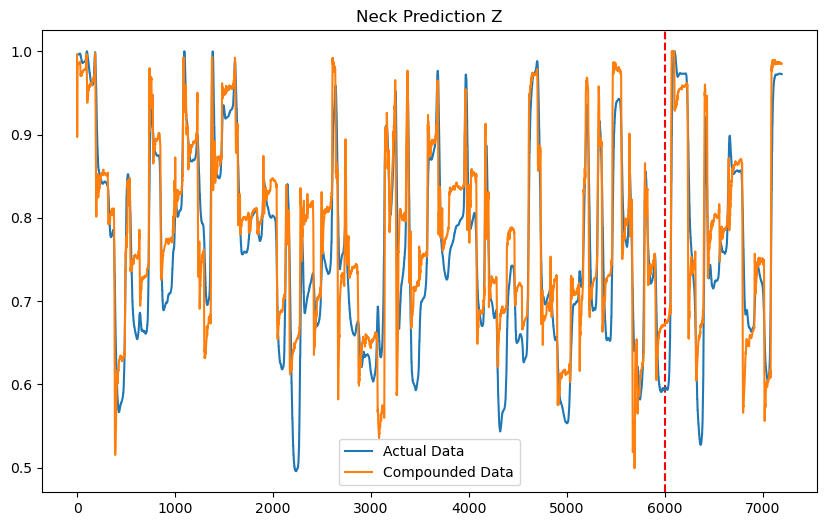

In [ ]:
plt.figure(figsize=(10,6))
plt.axvline(x=6000, c='r', linestyle="--")

plt.plot(dataY_plot[:, 2], label="Actual Data")
#plt.plot(data_predict[:, 2], label="Predicted Data")
plt.plot(data_compound[:, 2], label="Compounded Data")
plt.title("Neck Prediction Z")
plt.legend()
plt.show()

## Testing on New Series

In [ ]:
df = pd.read_csv("../EyeTrackingTest/Data/Test/2_1.txt", delimiter=",").iloc[:, :-1]

In [ ]:
labelx = []
labely = []
labelz = []
for i in range(df.shape[0] - 1):
    label_row = df.iloc[i + 1]
    labelx.append(label_row["forward.x"])
    labely.append(label_row["forward.y"])
    labelz.append(label_row["forward.z"])

df = df.iloc[:-1, :]
df["label.x"] = labelx
df["label.y"] = labely
df["label.z"] = labelz
df.head(5)

,time(100ns),time_stamp(ms),frame,gaze_direct_L.x,gaze_direct_L.y,gaze_direct_L.z,gaze_direct_R.x,gaze_direct_R.y,gaze_direct_R.z,forward.x,forward.y,forward.z,label.x,label.y,label.z
0,638001315885795054,181877,10229,0.002441,0.089676,0.995956,0.026138,0.096710,0.994965,0.032196,0.070567,0.996987,0.032279,0.070550,0.996986
1,638001315885875052,181885,10230,0.002487,0.090622,0.995880,0.026138,0.095886,0.995041,0.032279,0.070550,0.996986,0.032443,0.070451,0.996988
2,638001315885955057,181893,10231,0.002533,0.090637,0.995865,0.026108,0.096298,0.994995,0.032443,0.070451,0.996988,0.032568,0.070438,0.996984
3,638001315886045056,181902,10232,0.001099,0.088852,0.996033,0.025070,0.096069,0.995056,0.032568,0.070438,0.996984,0.032568,0.070438,0.996984
4,638001315886125064,181910,10232,0.000565,0.089035,0.996018,0.024841,0.095840,0.995071,0.032568,0.070438,0.996984,0.032711,0.070426,0.996981


In [ ]:
X = df.iloc[:, 3:-3].to_numpy()
y = df.iloc[:, -3:].to_numpy()

print(X.shape, y.shape)

(7200, 9) (7200, 3)


In [ ]:
X = Variable(torch.Tensor(X))
y = Variable(torch.Tensor(y))

X = torch.reshape(X, (X.shape[0], 1, X.shape[1]))

In [ ]:
train_predict, _, _ = lr_xyz(X.to(device))
data_predict = train_predict.data.cpu().numpy()
dataY_plot = y.data.numpy()

data_compound = [X[0, 0, 6:9].data.numpy()]
hn = None
cn = None
for i in range(X.size(0)):
    instance = X[i:i+1]
    pred, hn, cn = lr_xyz(instance.to(device), hn, cn)
    pred = pred.data.cpu().numpy()
    cur = X[i, 0, 6:9].data.numpy()
    data_compound.append(pred[0])
    if i < X.size(0) - 1:
        X[i+1,0,0:3] = nn.functional.normalize(torch.reshape(X[i+1,0,6:9] + X[i+1,0,0:3] - torch.Tensor(pred[0]), (1,3))).view(-1,3)
        X[i+1,0,3:6] = nn.functional.normalize(torch.reshape(X[i+1,0,6:9] + X[i+1,0,3:6] - torch.Tensor(pred[0]), (1,3))).view(-1,3)
        X[i+1,0,6] = pred[0,0].item()
        X[i+1,0,7] = pred[0,1].item()
        X[i+1,0,8] = pred[0,2].item()
data_compound = np.array(data_compound)
print(data_compound.shape)

plt.figure(figsize=(10,6))

plt.plot(data)
plt.plot(dataY_plot[:, 0], label="Actual Data")
plt.plot(data_compound[:, 0], label="Predicted Data")
plt.title("Neck Prediction X")
plt.legend()
plt.show()

(7201, 3)


NameError: name 'data' is not defined

<Figure size 1000x600 with 0 Axes>

In [ ]:
plt.figure(figsize=(10,6))

plt.plot(dataY_plot[:, 1], label="Actual Data")
plt.plot(data_compound[:, 1], label="Predicted Data")
plt.title("Neck Prediction Y")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10,6))

plt.plot(dataY_plot[:, 2], label="Actual Data")
plt.plot(data_compound[:, 2], label="Predicted Data")
plt.title("Neck Prediction Z")
plt.legend()
plt.show()